# Import Character Vocab


In [2]:
import numpy as np
import json
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
with open('files/vocab.json', 'r') as f:
  CHAR_INDICES = json.load(f)

In [5]:
print(CHAR_INDICES)

{' ': 0, '(': 1, ')': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'U': 35, 'V': 36, 'W': 37, 'X': 38, 'Y': 39, 'Z': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66, '[': 67, ']': 68, '<pad>': 69, '<unk>': 70, '.': 71, "'": 72}


# Preprocessing text data

## look_back

In [6]:
look_back = 10

In [7]:
def create_dataset(text, look_back = look_back):

  """
  take text with label (text that being defined where to cut ('|')) 
  and encode text and make label
  return preprocessed text & preprocessed label
  """
  X, y = [], []
  text = '|' + text
  data = [CHAR_INDICES['<pad>']] * look_back
  for i in range(1, len(text)):
    current_char = text[i]
    before_char = text[i-1]

    if current_char == '|':
      continue
    data = data[1:] + [CHAR_INDICES[current_char]]  # X data

    target = 1 if before_char == '|' else 0  # y data
    X.append(data)
    y.append(target)
  
  return np.array(X), tf.one_hot(y, 2)

In [8]:
def text_pred_preprocessing(text, sequence_len=look_back):
  """
    take unseen (testing) text and encode it with CHAR_DICT
    //It's like create_dataset() but not return label
    return preprocessed text
  """
  X = []
  data = [CHAR_INDICES['<pad>']] * sequence_len
  for char in text:
    char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
    data = data[1:] + [CHAR_INDICES[char]]  # X data
    X.append(data)
  return np.array(X)

In [9]:
def word_tokenize(text, class_):
    cut_indexs = []
    words = []

    # boolean index of each word 1 if cut before
    class_ = np.append(class_, 1)

    # if y_label at i is 1 so add i (index) to cut_indexs
    for i, value in enumerate(class_):
      if value == 1:
        cut_indexs.append(i)

    # add word after cutting till before ext cutting
    for i in range(len(cut_indexs)-1):
      words.append(text[cut_indexs[i]:cut_indexs[i+1]])
    
    return words

In [10]:
def decode_label(y):
  return tf.argmax(y, axis=-1).numpy()

## Import JSON

In [11]:
with open('../Web_Scraping/database/Dict_segment.json', 'r') as f1, open('../Web_Scraping/database/Dict_segment_cut.json', 'r') as f2:
  Dict = json.load(f1)
  Dict_cut = json.load(f2)

with open('../Web_Scraping/database/Dict_segment_12-7-20.json', 'r') as f1, open('../Web_Scraping/database/Dict_segment_cut_12-7-20.json', 'r') as f2:
  Dict_12_7_20 = json.load(f1)
  Dict_cut_12_7_20 = json.load(f2)

with open('../Web_Scraping/database/Dict_segment_12-2-20_hex.json', 'r') as f1, open('../Web_Scraping/database/Dict_segment_cut_12-2-20_hex.json', 'r') as f2:
  Dict_hex_12_2_20 = json.load(f1)
  Dict_hex_cut_12_2_20 = json.load(f2)

In [12]:
Dict_hex_cut_12_2_20['mixed_12-6-20'][:10]

['hex|yl|sti|bane',
 '1|,|2|-|di|deuterio|hex|ane',
 '1|,|4|-|di|deuterio|hex|ane',
 '1|,|5|-|di|deuterio|hex|ane',
 'hex|ane',
 '1|,|3|-|di|deuterio|pent|ane',
 '1|,|5|-|di|deuterio|pent|ane',
 '2|,|4|-|di|deuterio|pent|ane',
 '1|,|4|-|di|deuterio|pent|ane',
 '(|1|,|2|,|3|,|4|,|5|-|1|3|C|5|)|pent|ane']

In [13]:
"""
total_text = 0

for key, value in Dict.items():
    print(key, len(value))
    total_text += len(value)
print('-'*15)
for key, value in Dict_cut.items():
    print(key, len(value))
"""

"\ntotal_text = 0\n\nfor key, value in Dict.items():\n    print(key, len(value))\n    total_text += len(value)\nprint('-'*15)\nfor key, value in Dict_cut.items():\n    print(key, len(value))\n"

In [14]:
"""print('key Dict:',len(Dict.keys()))
print('ket Dict_cut:',len(Dict_cut.keys()))
print(f"There are {total_text} chemical in dataset")"""

'print(\'key Dict:\',len(Dict.keys()))\nprint(\'ket Dict_cut:\',len(Dict_cut.keys()))\nprint(f"There are {total_text} chemical in dataset")'

# Create Dataset

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
dataset_train_arr = []
dataset_val_arr = []

dataset_cut_train_arr = []
dataset_cut_val_arr = []

for key in Dict.keys():
    value_dict = Dict[key]
    value_dict_cut = Dict_cut[key]
    first_arr, second_arr, first_cut_arr, second_cut_arr = train_test_split(value_dict, value_dict_cut, test_size=0.2, random_state=123, shuffle=True)

    dataset_train_arr = np.concatenate((dataset_train_arr, first_arr), axis=0)
    dataset_val_arr = np.concatenate((dataset_val_arr, second_arr), axis=0)

    dataset_cut_train_arr = np.concatenate((dataset_cut_train_arr, first_cut_arr), axis=0)
    dataset_cut_val_arr = np.concatenate((dataset_cut_val_arr, second_cut_arr), axis=0)

mixed_dataset = np.concatenate((Dict_12_7_20['mixed_12-6-20'], Dict_hex_12_2_20['mixed_12-6-20']))
mixed_dataset_cut = np.concatenate((Dict_cut_12_7_20['mixed_12-6-20'], Dict_hex_cut_12_2_20['mixed_12-6-20']))

mixed_dataset_train, mixed_dataset_val, mixed_dataset_cut_train, mixed_dataset_cut_val = train_test_split(
    mixed_dataset, mixed_dataset_cut, test_size=0.2, random_state=123, shuffle=True
)

dataset_train_arr = np.concatenate((dataset_train_arr, mixed_dataset_train))
dataset_val_arr = np.concatenate((dataset_val_arr, mixed_dataset_val))
dataset_cut_train_arr = np.concatenate((dataset_cut_train_arr, mixed_dataset_cut_train))
dataset_cut_train_val = np.concatenate((dataset_cut_val_arr, mixed_dataset_cut_val))

print(' '.join(dataset_train_arr)[:101])
print(len(' '.join(dataset_train_arr).replace('|','')))
print('-'*25)
print(' '.join(dataset_cut_train_arr)[:73])
print(len(' '.join(dataset_cut_train_arr).replace('|','')))

octane hexane nonane butane ethane heptane decane propane 2,3,4,4-tetramethylhexane 3-ethyl-3-methylh
261143
-------------------------
oct|ane hex|ane non|ane but|ane eth|ane hept|ane dec|ane prop|ane 2|,|3|,
261142


In [17]:
dataset_train_text = ' '.join(dataset_train_arr)
dataset_val_text = ' '.join(dataset_val_arr)
dataset_cut_train_text = '| |'.join(dataset_cut_train_arr)
dataset_cut_val_text = '| |'.join(dataset_cut_val_arr)

print(dataset_train_arr.shape)
print(dataset_train_text[:67])
print(dataset_cut_train_arr.shape)
print(dataset_cut_train_text[:99])
print('-'*20)

print(dataset_val_arr.shape)
print(dataset_val_text[:74])
print(dataset_cut_val_arr.shape)
print(dataset_cut_val_text[:113])

(6549,)
octane hexane nonane butane ethane heptane decane propane 2,3,4,4-t
(6549,)
oct|ane| |hex|ane| |non|ane| |but|ane| |eth|ane| |hept|ane| |dec|ane| |prop|ane| |2|,|3|,|4|,|4|-|t
--------------------
(1651,)
pentane methane 3-bromo-3-(bromomethyl)pentane 3-iodo-3-methylpentane 1,2,
(199,)
pent|ane| |meth|ane| |3|-|bromo|-|3|-|(|bromo|meth|yl|)|pent|ane| |3|-|iodo|-|3|-|meth|yl|pent|ane| |1|,|2|,|3|-|


In [18]:
X_train ,y_train = create_dataset(dataset_cut_train_text)
X_val, y_val = create_dataset(dataset_cut_val_text)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(261142, 10) (261142, 2)
(4734, 10) (4734, 2)


In [19]:
training_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
training_data = training_data.batch(512).cache().prefetch(tf.data.experimental.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_data = validation_data.batch(512).cache().prefetch(tf.data.experimental.AUTOTUNE)

#print(tf.shape(training_data))

# Create Model

## Model Architecture

In [20]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GRU, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [21]:
_input_shape = (look_back, len(CHAR_INDICES))
print(_input_shape[1])

73


In [22]:
Model = Sequential(
    [
     Embedding(len(CHAR_INDICES), 64),
     Bidirectional(LSTM(32, return_sequences=False), merge_mode='concat'),
     Dense(32, activation='relu'),
     Dense(2, activation='softmax')
    ],
    name='model'
)

In [23]:
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          4672      
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 31,650
Trainable params: 31,650
Non-trainable params: 0
_________________________________________________________________


## Training Model (with callback)


In [24]:
Model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = 'save_models/best_model.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callback_list = [checkpoint_callback, earlystop_callback, reduce_lr]
history = Model.fit(training_data, validation_data=validation_data, epochs=500, callbacks=callback_list)

Epoch 1/500
511/511 [==============================] - 7s 7ms/step - loss: 0.3180 - accuracy: 0.8695 - val_loss: 0.0897 - val_accuracy: 0.9742
Epoch 2/500
511/511 [==============================] - 4s 7ms/step - loss: 0.0539 - accuracy: 0.9835 - val_loss: 0.0487 - val_accuracy: 0.9861
Epoch 3/500
511/511 [==============================] - 3s 6ms/step - loss: 0.0309 - accuracy: 0.9906 - val_loss: 0.0379 - val_accuracy: 0.9918
Epoch 4/500
511/511 [==============================] - 3s 6ms/step - loss: 0.0230 - accuracy: 0.9935 - val_loss: 0.0338 - val_accuracy: 0.9932
Epoch 5/500
511/511 [==============================] - 3s 6ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.0316 - val_accuracy: 0.9941
Epoch 6/500
511/511 [==============================] - 3s 6ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0303 - val_accuracy: 0.9943
Epoch 7/500
511/511 [==============================] - 3s 6ms/step - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.0280 - val_accuracy: 0.9943

##  Plot loss function and accuracy

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


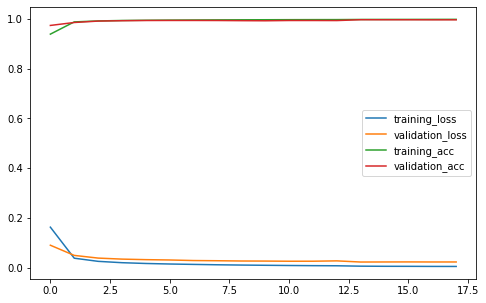

In [25]:
print(type(history.history))
print(history.history.keys())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.plot(history.history['accuracy'], label='training_acc')
plt.plot(history.history['val_accuracy'], label='validation_acc')
plt.legend()
plt.show()

# Import model and Test on unseen data

In [26]:
best_model = tf.keras.models.load_model('save_models/best_model.hdf5')
best_model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
test_data_text = 'methyl methanoate'
test_data_text_cut = 'meth|yl| |meth|an|oate'

In [32]:
_, my_y = create_dataset(test_data_text_cut)
myText_test = text_pred_preprocessing(test_data_text)

pred_test_proba = best_model.predict(myText_test)

pred_test = decode_label(pred_test_proba)
pred_test[0] = 1
my_y_decode = decode_label(my_y)

print(pred_test)
print(my_y_decode)

# Count same item between y (label) and pred (prediction)
elem_same = (pred_test == my_y_decode).sum()
print("\nSame =",elem_same,", Not Same =",pred_test.shape[0]-elem_same)

[1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0]
[1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0]

Same = 17 , Not Same = 0


In [33]:
words = word_tokenize(test_data_text, pred_test)
print(words)
print('|'.join(words))

['meth', 'yl', ' ', 'meth', 'an', 'oate']
meth|yl| |meth|an|oate


# Function Confusion Matrix visualization

# Plot Confusion Matrix

In [34]:
from nami.visualize import plot_confusion_matrix
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]
plot_confusion_matrix(tf.math.confusion_matrix(my_y_decode, pred_test, num_classes=2).numpy(), 
                      group_names=labels,
                      categories=categories, cmap='YlGnBu')

ModuleNotFoundError: No module named 'seaborn'

## BLEU Score

In [30]:
reference = test_data_text_cut.split('|')
print(reference)

['4', '-', 'hydroxy', '-', '2', '-', 'meth', 'yl', '-', '3', '-', 'meth', 'yl', 'idene', '-', '6', '-', 'oxo', 'cyclo', 'hex', 'a', '-', '1', ',', '4', '-', 'di', 'ene', '-', '1', '-', 'carboxylic acid']


In [31]:
import nltk
score = nltk.translate.bleu_score.sentence_bleu([reference],words)
print(score)

0.8498644646741501
